# Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install transformers datasets scikit-learn -q

import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, pipeline
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
from scipy.special import softmax


from google.colab import files
csv_path = "/content/drive/MyDrive/AIP4/data/movie_metadata.csv"
df = pd.read_csv(csv_path)



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 18.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12=

Metadata Processing if needed.

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer
from collections import Counter
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

reviews_df = pd.read_csv("/content/drive/MyDrive/AIP4/data/rotten_tomatoes_critic_reviews.csv")

# remove reviews with no review content
reviews_df.replace('', np.nan, inplace=True)
reviews_df = reviews_df.dropna(subset=['review_content'])

# randomly drop n rows -> sentiment analysis is time consuming
n = int(len(reviews_df) // 1.03) # this is for scaling purposes since the data set is quite large
drop_indices = np.random.choice(reviews_df.index, n, replace=False)
reviews_df = reviews_df.drop(drop_indices)

# testing limits on how many reviews I have per movie
reviews_df = reviews_df.groupby('rotten_tomatoes_link').head(20)

movies_df = pd.read_csv("/content/drive/MyDrive/AIP4/data/rotten_tomatoes_movies.csv")

# encoding
reviews_df['top_critic'] = reviews_df['top_critic'].replace({True: 1, False: 0})

print("Normalizing genres...")
movies_df['genre_list'] = movies_df['genres'].fillna("").apply(lambda x: [g.strip() for g in x.split(',')])
mlb = MultiLabelBinarizer()
genre_dummies = pd.DataFrame(
    mlb.fit_transform(movies_df['genre_list']),
    columns=[f"genre_{g}" for g in mlb.classes_]
)
movies_df = pd.concat([movies_df, genre_dummies], axis=1)
movies_df.drop(columns=['genres', 'genre_list'], inplace=True)

print("Parsing top directors...")
movies_df['director_list'] = movies_df['directors'].fillna("").apply(lambda x: [a.strip() for a in x.split(',')])
director_counter = Counter(director for sublist in movies_df['director_list'] for director in sublist)
top_directors = [a for a, _ in director_counter.most_common(200)]
for director in top_directors:
    movies_df[f'director_{director}'] = movies_df['director_list'].apply(lambda lst: int(director in lst))
movies_df.drop(columns=['directors', 'director_list'], inplace=True)

print("Parsing top writers...")
movies_df['authors_list'] = movies_df['authors'].fillna("").apply(lambda x: [a.strip() for a in x.split(',')])
authors_counter = Counter(author for sublist in movies_df['authors_list'] for author in sublist)
top_authors = [a for a, _ in authors_counter.most_common(200)]
for author in top_authors:
    movies_df[f'author_{author}'] = movies_df['authors_list'].apply(lambda lst: int(author in lst))
movies_df.drop(columns=['authors', 'authors_list'], inplace=True)

print("Parsing top actors...")
movies_df['actor_list'] = movies_df['actors'].fillna("").apply(lambda x: [a.strip() for a in x.split(',')])
actor_counter = Counter(actor for sublist in movies_df['actor_list'] for actor in sublist)
top_actors = [a for a, _ in actor_counter.most_common(500)]
for actor in top_actors:
    movies_df[f'actor_{actor}'] = movies_df['actor_list'].apply(lambda lst: int(actor in lst))
movies_df.drop(columns=['actors', 'actor_list'], inplace=True)


merged_df = pd.merge(reviews_df, movies_df, on='rotten_tomatoes_link', how='inner')

print("Normalizing critic scores...")


def clean_score(raw_score):
    # Normalize scores since there's a lot of variety in how an individual critic scores a movie.
    if pd.isnull(raw_score):
        return None

    raw_score = str(raw_score).strip()

    # Handle fractions
    if '/' in raw_score:
        try:
            num, denom = raw_score.split('/')
            return round((float(num) / float(denom)) * 10, 1)
        except:
            return None

    # Handle letter grades
    letter_map = {
        'A+': 10.0, 'A': 9.5, 'A-': 9.0,
        'B+': 8.5, 'B': 8.0, 'B-': 7.5,
        'C+': 7.0, 'C': 6.5, 'C-': 6.0,
        'D+': 5.5, 'D': 5.0, 'D-': 4.5,
        'F': 3.0  # generous assumption
    }

    if raw_score.upper() in letter_map:
        return letter_map[raw_score.upper()]

    return None  # Couldn't parse, likely due to some weird score I don't want to account for

merged_df['review_score_clean'] = merged_df['review_score'].apply(clean_score)
merged_df = merged_df.dropna(subset=['review_score_clean'])
merged_df.drop(columns=['review_score'], inplace=True)

# remove unused data
print("Dropping unused keys...")
# A lot of this data is parsed by this point or isn't relevant to the training model.
merged_df = merged_df.drop(columns=['genres',
                                    'directors',
                                    'actors',
                                    'authors',
                                    'runtime',
                                    'tomatometer_rotten_critics_count',
                                    'tomatometer_fresh_critics_count',
                                    'tomatometer_top_critics_count',
                                    'tomatometer_count',
                                    'tomatometer_status',
                                    'authors',
                                    'fv',
                                    'production_company',
                                    'publisher_name',
                                    'review_date',
                                    'content_rating',
                                    'critics_consensus',
                                    'original_release_date',
                                    'streaming_release_date',
                                    'audience_status',
                                    'audience_rating',
                                    'audience_count',
                                    'rotten_tomatoes_link',
                                    'critic_name',
                                    'review_type',
                                    'movie_title',
                                    'movie_info'],
                                    errors='ignore')

print("Writing data... This will take a few minutes")
merged_df.to_csv("/content/drive/MyDrive/AIP4/data/movie_metadata.csv", index=False)



<ipython-input-4-8bebef8d39bb>:23: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  reviews_df['top_critic'] = reviews_df['top_critic'].replace({True: 1, False: 0})


Normalizing critic scores...


<ipython-input-4-8bebef8d39bb>:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df.drop(columns=['review_score'], inplace=True)


Dropping unused keys...
Writing data... This will take a few minutes


# Sentiment Analysis Models

Perform Sentiment Analysis using the VADER Sentiment Analysis Lexicon

In [ ]:
import nltk
import pandas as pd
from warnings import simplefilter
from nltk.sentiment.vader import SentimentIntensityAnalyzer

simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

nltk.download('vader_lexicon')

vader_movie_df = pd.read_csv(csv_path)

print("Generating VADER sentiment scores")
sid = SentimentIntensityAnalyzer()

vader_movie_df['sentiment'] = vader_movie_df['review_content'].apply(lambda x: sid.polarity_scores(str(x))['compound'])

# remove unused data
print("Dropping unused keys...")
vader_movie_df = vader_movie_df.drop(columns=['review_content'], errors='ignore')

# isolate from meta data if desired
# vader_movie_df = vader_movie_df[['review_score_clean','sentiment']]

out_csv_path = "/content/drive/MyDrive/AIP4/data/sentiment_meta/vader.csv"
vader_movie_df.to_csv(out_csv_path, index=False)

print("Processing complete")


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


Generating VADER sentiment scores
Dropping unused keys...
Processing complete


Perform Sentiment Analysis using Distilled RoBERTa

In [ ]:
import pandas as pd
from warnings import simplefilter
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

movie_df  = pd.read_csv(csv_path)

print("Generating sentiment scores")
model_name = "j-hartmann/emotion-english-distilroberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
emotion_pipeline = pipeline("text-classification", model=model, tokenizer=tokenizer, return_all_scores=True)
unmasker = pipeline('fill-mask', model='distilroberta-base')

def get_emotion_scores(x):

    pipeline_input = x if isinstance(x, str) else str(x)
    output = emotion_pipeline(pipeline_input)[0]
    return {entry['label']: entry['score'] for entry in output}

movie_df['sentiment'] = movie_df['review_content'].apply(get_emotion_scores)

# remove unused data
print("Dropping unused keys...")
movie_df = movie_df.drop(columns=['review_content'], errors='ignore')

# isolate from meta data if desired
# movie_df = movie_df[['review_score_clean','sentiment']]
sentiment_df = pd.json_normalize(movie_df['sentiment'])

movie_df = pd.concat([movie_df.drop(columns=['sentiment']), sentiment_df], axis=1)

out_csv_path = "/content/drive/MyDrive/AIP4/data/sentiment_meta/distilled_roberta.csv"
movie_df.to_csv(out_csv_path, index=False)
print("Processing complete")


Generating sentiment scores


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/294 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/329M [00:00<?, ?B/s]

Device set to use cuda:0
/usr/local/lib/python3.11/dist-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/331M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaForMaskedLM: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


model.safetensors:   0%|          | 0.00/329M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cuda:0
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Dropping unused keys...
Processing complete


Perform Sentiment Analysis using Twitter RoBERTa

In [ ]:
import pandas as pd
from warnings import simplefilter
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax

movie_df  = pd.read_csv(csv_path)

print("Generating sentiment scores... This will take a few minutes")

model_name = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
labels = ['negative', 'neutral', 'positive']

def get_cardiff_sentiment(text):
    try:
        encoded = tokenizer(text, return_tensors='pt', truncation=True, max_length=512)
        with torch.no_grad():
            output = model(**encoded)
        scores = softmax(output.logits.numpy()[0])
        return {label: float(score) for label, score in zip(labels, scores)}
    except Exception as e:
        print(f"Error processing text: {text[:30]}... => {e}")
        return {label: None for label in labels}

movie_df['sentiment'] = movie_df['review_content'].astype(str).apply(get_cardiff_sentiment)

# remove unused data
print("Dropping unused keys...")
movie_df = movie_df.drop(columns=['review_content'], errors='ignore')

# isolate from meta data if desired
# movie_df = movie_df[['review_score_clean','sentiment']]
sentiment_df = pd.json_normalize(movie_df['sentiment'])

movie_df = pd.concat([movie_df.drop(columns=['sentiment']), sentiment_df], axis=1)

out_csv_path = "/content/drive/MyDrive/AIP4/data/sentiment_meta/twitter_roberta.csv"
movie_df.to_csv(out_csv_path, index=False)

print("Processing complete")


Generating sentiment scores... This will take a few minutes


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Dropping unused keys...
Processing complete


# Prediction Testing

Train With Linear Regression (Sentiment Only)

VADER
R²:  0.053079085686117966
Match Rate:  0.07811786203746003


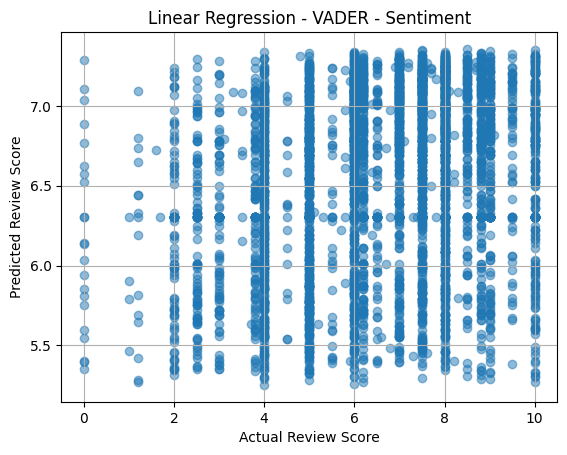

VADER with Sentiment
R²:  0.357848992461263
Match Rate:  0.12185642432556013


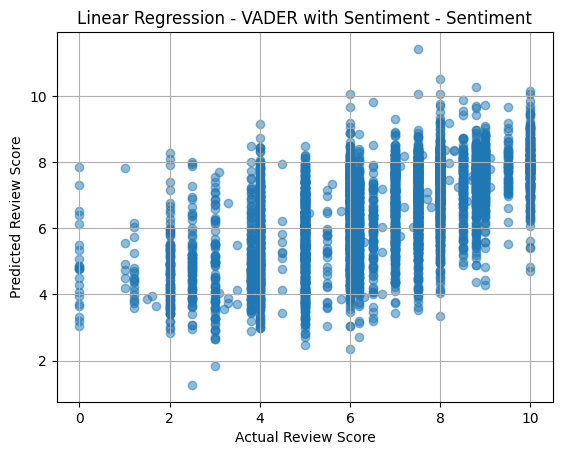

FilmBERT
R²:  0.5006611701681523
Match Rate:  0.15189584285061672


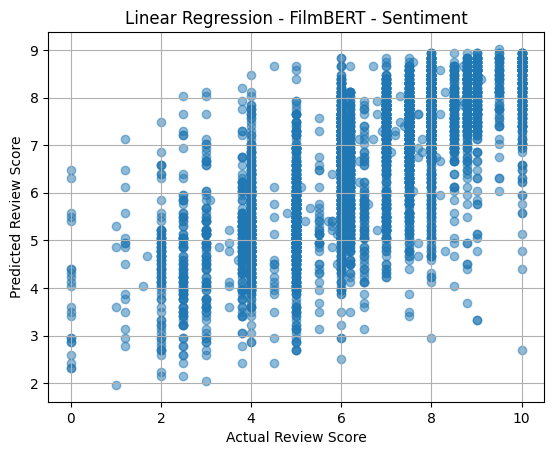

FilmBERT with Sentiment
R²:  0.5644099292743079
Match Rate:  0.15432098765432098


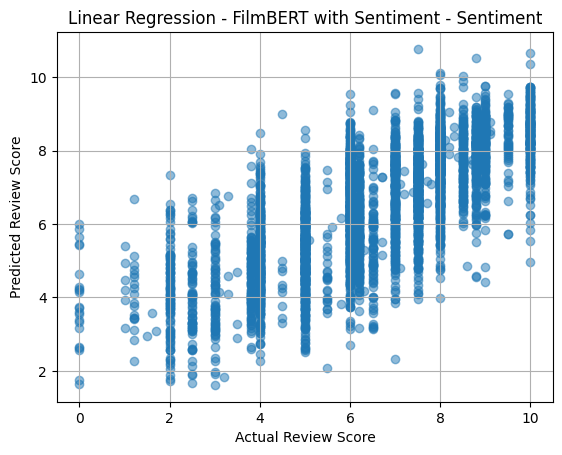

Distilled RoBERTa
R²:  0.110809423534032
Match Rate:  0.08222932846048424


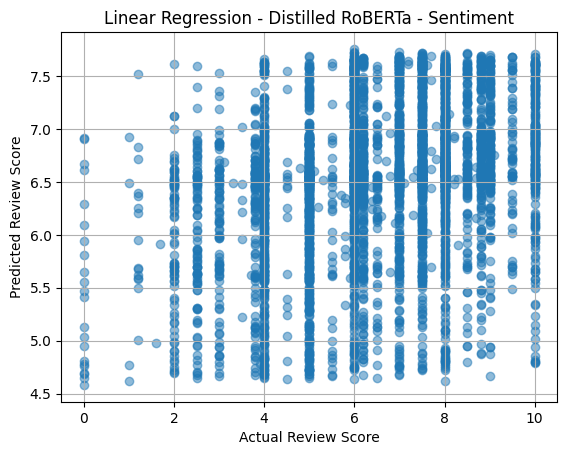

Distilled RoBERTa with Sentiment
R²:  0.3819640087816366
Match Rate:  0.1259716506630087


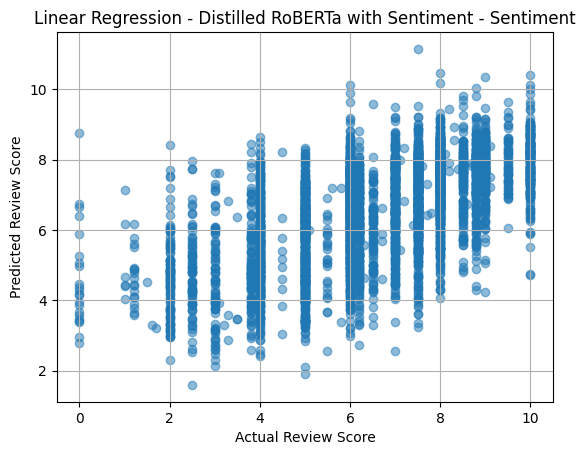

Twitter RoBERTa
R²:  0.2737462424654884
Match Rate:  0.13202375513933304


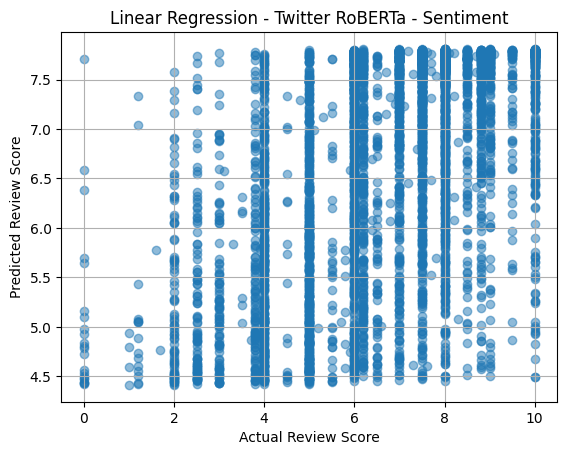

Twitter RoBERTa with Sentiment
R²:  0.4576456696138148
Match Rate:  0.13534522176497485


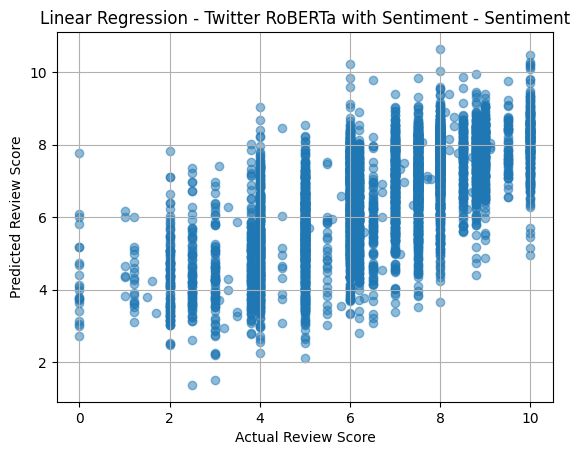

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import numpy as np


def loop(model_name, score_path):
    film_df = pd.read_csv(score_path, header=0)
    film_df = film_df.dropna()
    X = film_df.drop(columns=['review_score_clean'], axis=1)
    y = film_df['review_score_clean']

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Split into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    print("R²: ", r2)

    match_rate = np.mean(np.abs(y_pred - y_test) < .25)  # .25-point margin
    print("Match Rate: ", match_rate)

    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.xlabel('Actual Review Score')
    plt.ylabel('Predicted Review Score')
    plt.title(f"Linear Regression - {model_name} - Sentiment")
    plt.grid(True)
    plt.show()

sentiment_list = {
    "VADER": "/content/drive/MyDrive/AIP4/data/sentiment/vader.csv",
    "VADER with Sentiment": "/content/drive/MyDrive/AIP4/data/sentiment_meta/vader.csv",
    "FilmBERT": "/content/drive/MyDrive/AIP4/data/sentiment/film_bert.csv",
    "FilmBERT with Sentiment": "/content/drive/MyDrive/AIP4/data/sentiment_meta/film_bert.csv",
    "Distilled RoBERTa": "/content/drive/MyDrive/AIP4/data/sentiment/distilled_roberta.csv",
    "Distilled RoBERTa with Sentiment": "/content/drive/MyDrive/AIP4/data/sentiment_meta/distilled_roberta.csv",
    "Twitter RoBERTa": "/content/drive/MyDrive/AIP4/data/sentiment/twitter_roberta.csv",
    "Twitter RoBERTa with Sentiment": "/content/drive/MyDrive/AIP4/data/sentiment_meta/twitter_roberta.csv"
}

for key in sentiment_list:
    print(key)
    score_path = sentiment_list[key]
    loop(key, score_path)


Train with LightGBM (Sentiment Only)

VADER
R²: 0.039971732454656794
Match Rate:  0.08245774326176336


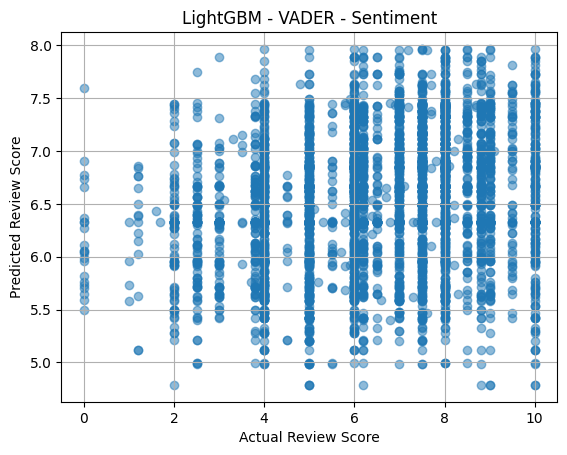

VADER with Sentiment
R²: 0.08877871060390985
Match Rate:  0.10791037951531779


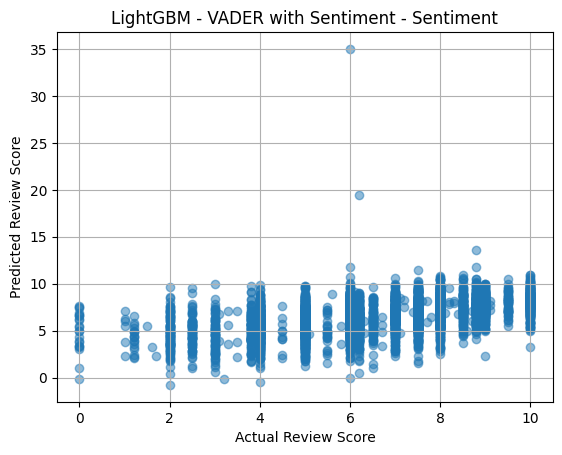

FilmBERT
R²: 0.5011799729268458
Match Rate:  0.16194609410689811


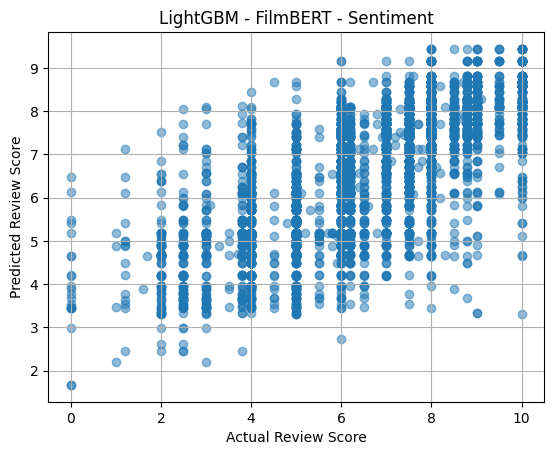

FilmBERT with Sentiment
R²: 0.22863960481053514
Match Rate:  0.12985825331504344


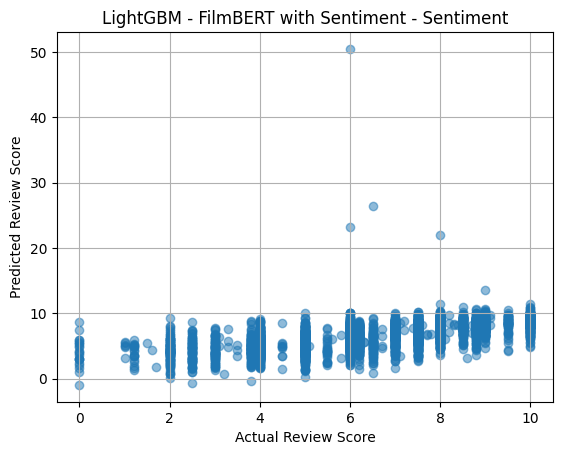

Distilled RoBERTa
R²: -0.08108268686671072
Match Rate:  0.10415714938328004


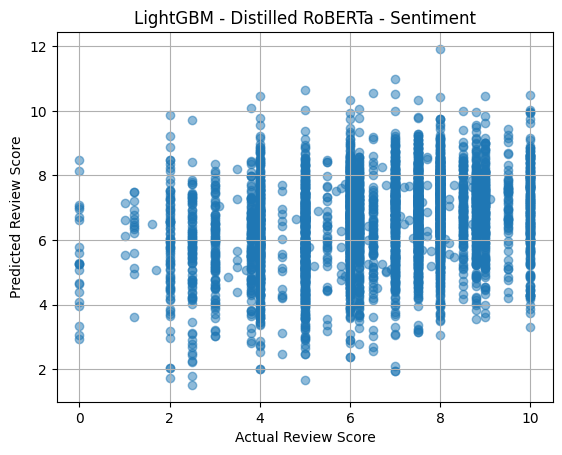

Distilled RoBERTa with Sentiment
R²: 0.24550519956170858
Match Rate:  0.13305898491083676


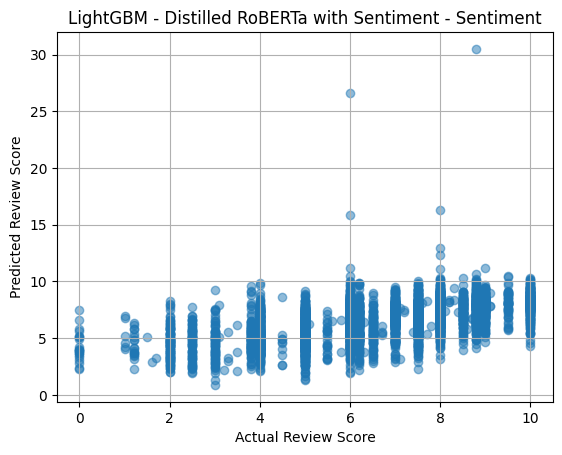

Twitter RoBERTa
R²: -0.04330494007046659
Match Rate:  0.09913202375513934


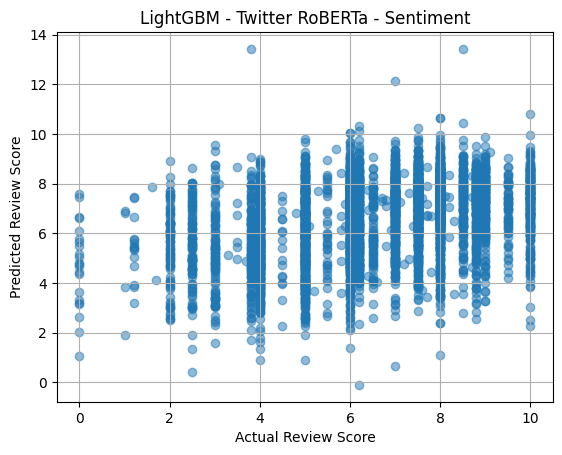

Twitter RoBERTa with Sentiment
R²: 0.1189030660502538
Match Rate:  0.12437128486511202


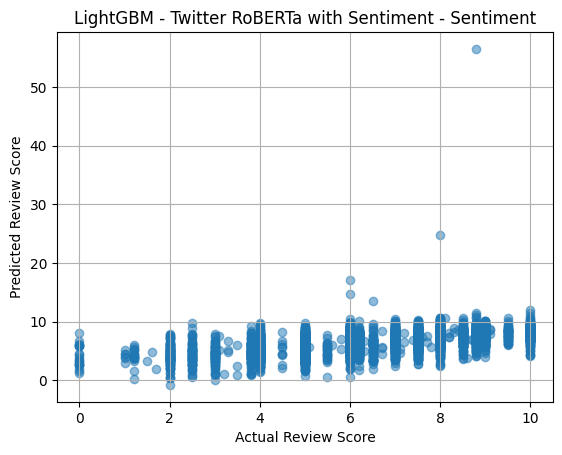

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import numpy as np
import lightgbm as lgb

def loop(model_name, score_path):
    film_df = pd.read_csv(score_path, header=0)
    film_df = film_df.dropna()
    X = film_df.drop(columns=['review_score_clean'], axis=1)
    y = film_df['review_score_clean']

    # Split into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = lgb.LGBMRegressor(n_estimators=5000, learning_rate=0.2, max_depth=30, verbose=-1)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    y_true  = y_test.values if hasattr(y_test, "values") else y_test

    r2 = r2_score(y_test, y_pred)
    print("R²:", r2)

    match_rate = np.mean(np.abs(y_pred - y_test) < .25)  # .25-point margin
    print("Match Rate: ", match_rate)

    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.xlabel('Actual Review Score')
    plt.ylabel('Predicted Review Score')
    plt.title(f"LightGBM - {model_name} - Sentiment")
    plt.grid(True)
    plt.show()

sentiment_list = {
    "VADER": "/content/drive/MyDrive/AIP4/data/sentiment/vader.csv",
    "VADER with Sentiment": "/content/drive/MyDrive/AIP4/data/sentiment_meta/vader.csv",
    "FilmBERT": "/content/drive/MyDrive/AIP4/data/sentiment/film_bert.csv",
    "FilmBERT with Sentiment": "/content/drive/MyDrive/AIP4/data/sentiment_meta/film_bert.csv",
    "Distilled RoBERTa": "/content/drive/MyDrive/AIP4/data/sentiment/distilled_roberta.csv",
    "Distilled RoBERTa with Sentiment": "/content/drive/MyDrive/AIP4/data/sentiment_meta/distilled_roberta.csv",
    "Twitter RoBERTa": "/content/drive/MyDrive/AIP4/data/sentiment/twitter_roberta.csv",
    "Twitter RoBERTa with Sentiment": "/content/drive/MyDrive/AIP4/data/sentiment_meta/twitter_roberta.csv"
}

for key in sentiment_list:
    print(key)
    score_path = sentiment_list[key]
    loop(key, score_path)

Train with Random Forest (Sentiment Only)

VADER
R²: -0.04866159710084772
Match Rate:  0.08268615806304248


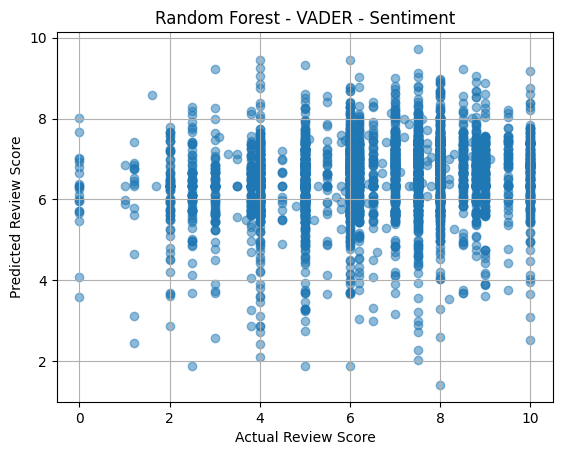

VADER with Sentiment
R²: 0.34313143113199807
Match Rate:  0.11957018747142203


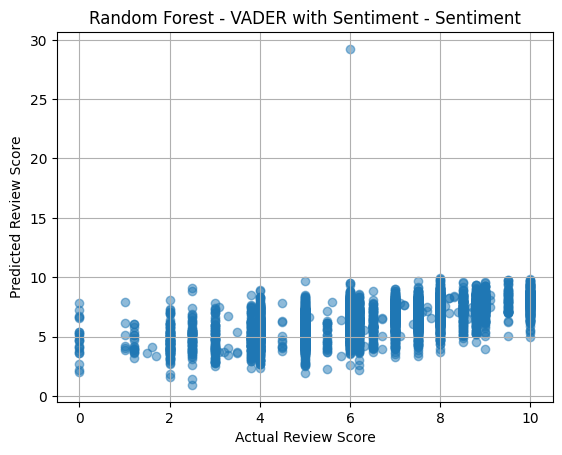

FilmBERT
R²: 0.5010076939035426
Match Rate:  0.16194609410689811


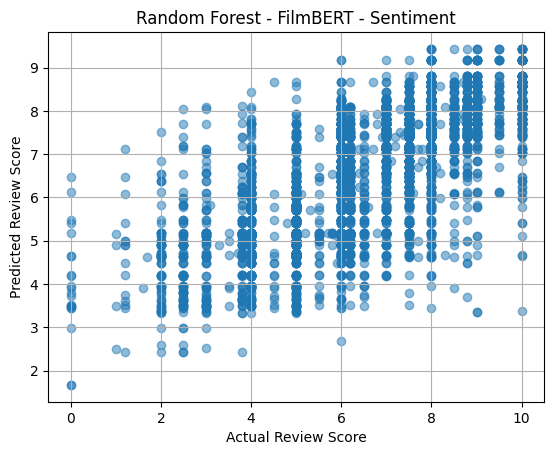

FilmBERT with Sentiment
R²: 0.46956780646431295
Match Rate:  0.15843621399176955


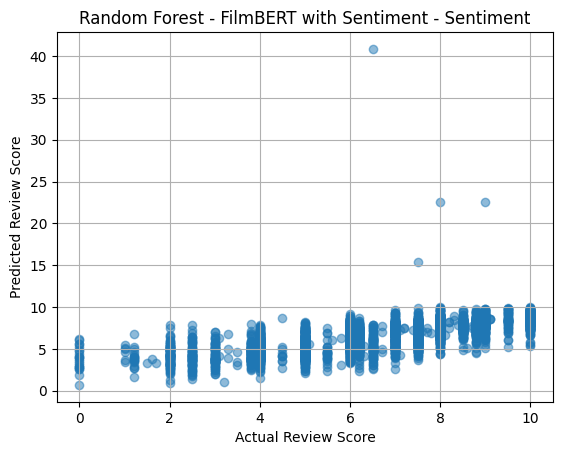

Distilled RoBERTa
R²: 0.1307082623694068
Match Rate:  0.10872544540886249


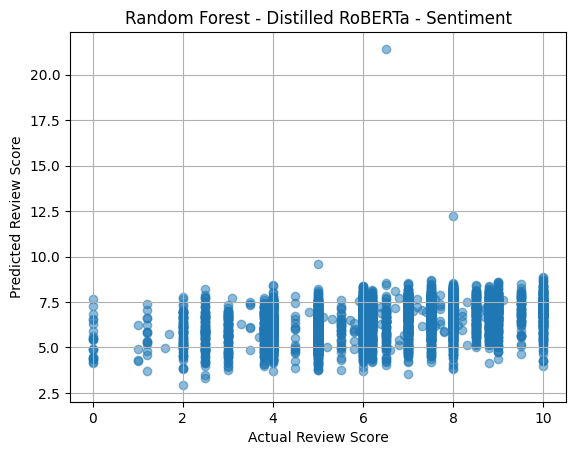

Distilled RoBERTa with Sentiment
R²: 0.12210321958848169
Match Rate:  0.14380429812528578


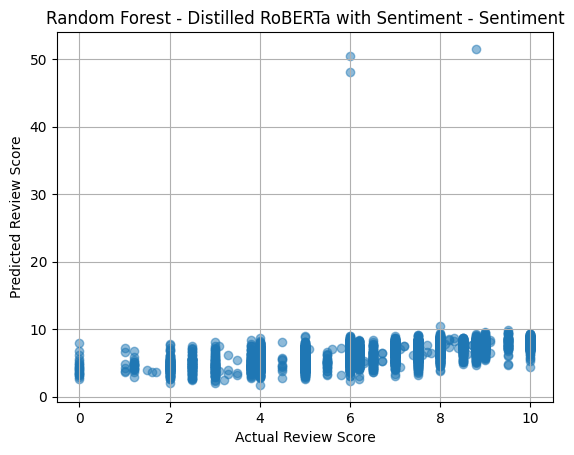

Twitter RoBERTa
R²: 0.1697272923931039
Match Rate:  0.11512105984467794


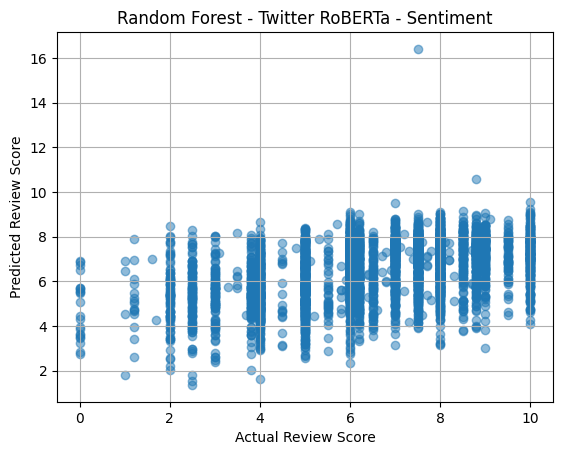

Twitter RoBERTa with Sentiment
R²: 0.4429996249297996
Match Rate:  0.14060356652949246


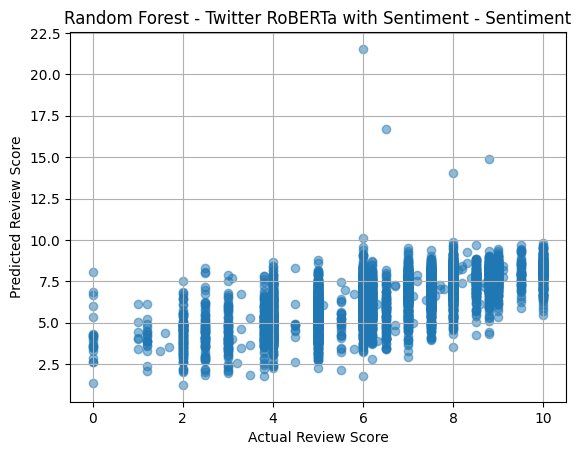

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import numpy as np

def loop(model_name, score_path):
    film_df = pd.read_csv(score_path, header=0)
    film_df = film_df.dropna()
    X = film_df.drop(columns=['review_score_clean'], axis=1)
    y = film_df['review_score_clean']

    # Split into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train the model
    model = RandomForestRegressor(n_estimators=200, max_depth=30, random_state=42)
    model.fit(X_train, y_train)

    # Predict
    y_pred = model.predict(X_test)

    y_true  = y_test.values if hasattr(y_test, "values") else y_test

    r2 = r2_score(y_test, y_pred)
    print("R²:", r2)

    match_rate = np.mean(np.abs(y_pred - y_test) < .25)  # .25-point margin
    print("Match Rate: ", match_rate)

    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.xlabel('Actual Review Score')
    plt.ylabel('Predicted Review Score')
    plt.title(f"Random Forest - {model_name} - Sentiment")
    plt.grid(True)
    plt.show()

sentiment_list = {
    "VADER": "/content/drive/MyDrive/AIP4/data/sentiment/vader.csv",
    "VADER with Sentiment": "/content/drive/MyDrive/AIP4/data/sentiment_meta/vader.csv",
    "FilmBERT": "/content/drive/MyDrive/AIP4/data/sentiment/film_bert.csv",
    "FilmBERT with Sentiment": "/content/drive/MyDrive/AIP4/data/sentiment_meta/film_bert.csv",
    "Distilled RoBERTa": "/content/drive/MyDrive/AIP4/data/sentiment/distilled_roberta.csv",
    "Distilled RoBERTa with Sentiment": "/content/drive/MyDrive/AIP4/data/sentiment_meta/distilled_roberta.csv",
    "Twitter RoBERTa": "/content/drive/MyDrive/AIP4/data/sentiment/twitter_roberta.csv",
    "Twitter RoBERTa with Sentiment": "/content/drive/MyDrive/AIP4/data/sentiment_meta/twitter_roberta.csv"
}

for key in sentiment_list:
    print(key)
    score_path = sentiment_list[key]
    loop(key, score_path)



Train with Ridge Regression (Sentiment Only)

VADER
R²: -0.04866159710084772
Match Rate:  0.08268615806304248


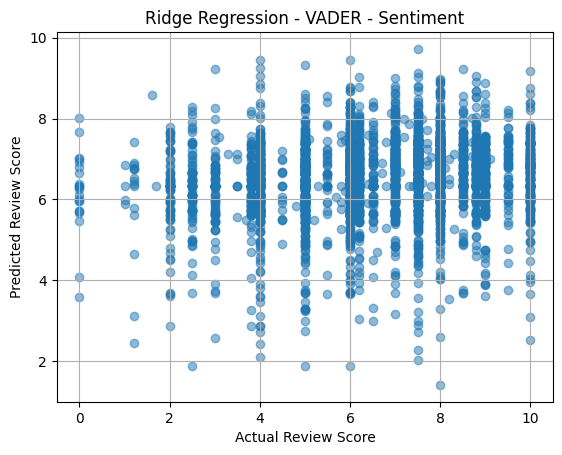

VADER with Sentiment
R²: 0.34313143113199807
Match Rate:  0.11957018747142203


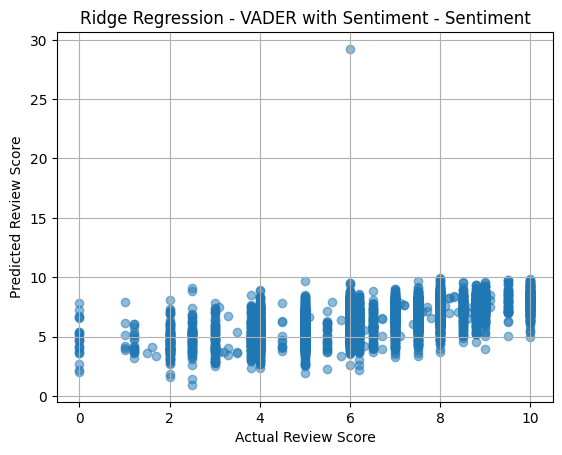

FilmBERT
R²: 0.5010076939035426
Match Rate:  0.16194609410689811


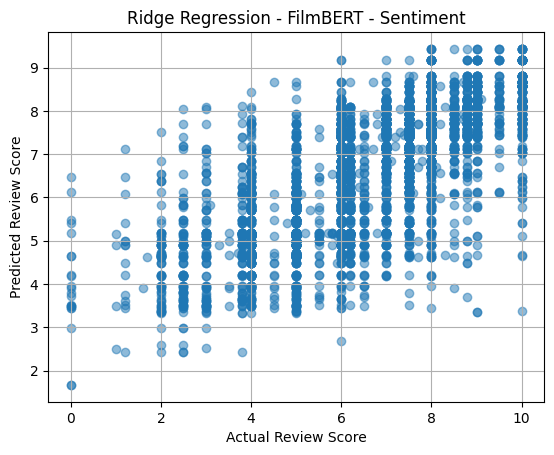

FilmBERT with Sentiment
R²: 0.46956780646431295
Match Rate:  0.15843621399176955


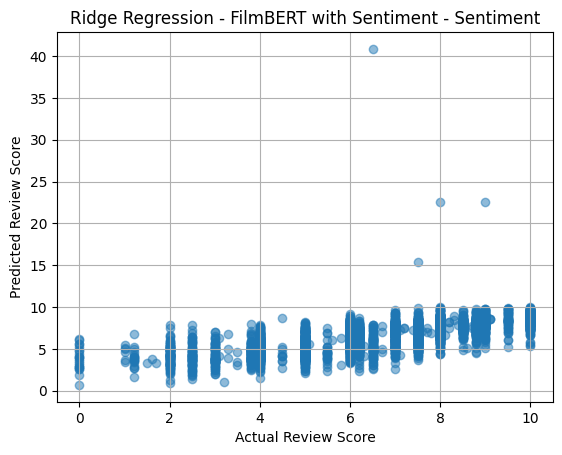

Distilled RoBERTa
R²: 0.1307082623694068
Match Rate:  0.10872544540886249


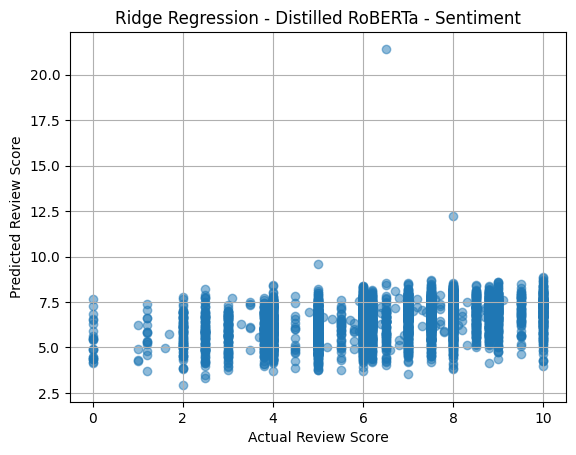

Distilled RoBERTa with Sentiment
R²: 0.12210321958848169
Match Rate:  0.14380429812528578


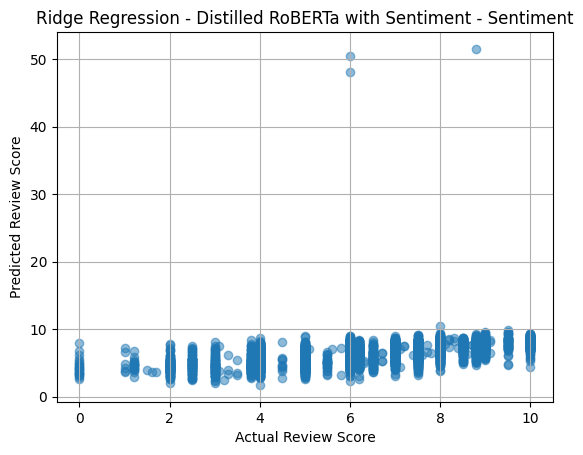

Twitter RoBERTa
R²: 0.1697272923931039
Match Rate:  0.11512105984467794


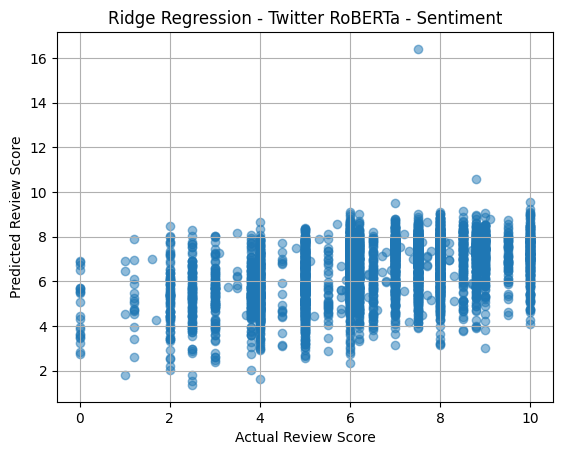

Twitter RoBERTa with Sentiment
R²: 0.4429996249297996
Match Rate:  0.14060356652949246


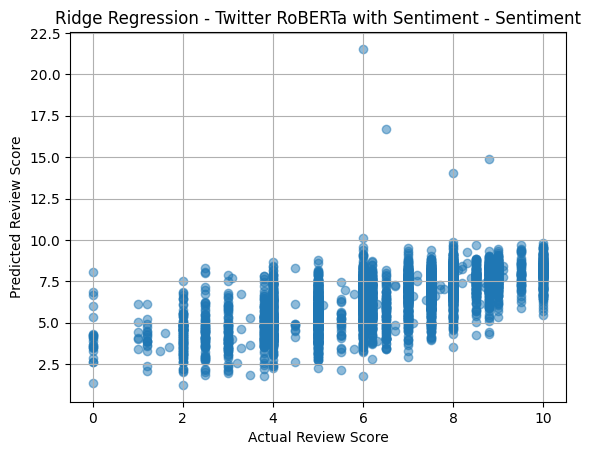

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import numpy as np

def loop(model_name, score_path):
    film_df = pd.read_csv(score_path, header=0)
    film_df = film_df.dropna()
    X = film_df.drop(columns=['review_score_clean'], axis=1)
    y = film_df['review_score_clean']

    # Split into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train the model
    model = RandomForestRegressor(n_estimators=200, max_depth=30, random_state=42)
    model.fit(X_train, y_train)

    # Predict
    y_pred = model.predict(X_test)

    y_true  = y_test.values if hasattr(y_test, "values") else y_test

    r2 = r2_score(y_test, y_pred)
    print("R²:", r2)

    match_rate = np.mean(np.abs(y_pred - y_test) < .25)  # .25-point margin
    print("Match Rate: ", match_rate)

    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.xlabel('Actual Review Score')
    plt.ylabel('Predicted Review Score')
    plt.title(f"Ridge Regression - {model_name} - Sentiment")
    plt.grid(True)
    plt.show()

sentiment_list = {
    "VADER": "/content/drive/MyDrive/AIP4/data/sentiment/vader.csv",
    "VADER with Sentiment": "/content/drive/MyDrive/AIP4/data/sentiment_meta/vader.csv",
    "FilmBERT": "/content/drive/MyDrive/AIP4/data/sentiment/film_bert.csv",
    "FilmBERT with Sentiment": "/content/drive/MyDrive/AIP4/data/sentiment_meta/film_bert.csv",
    "Distilled RoBERTa": "/content/drive/MyDrive/AIP4/data/sentiment/distilled_roberta.csv",
    "Distilled RoBERTa with Sentiment": "/content/drive/MyDrive/AIP4/data/sentiment_meta/distilled_roberta.csv",
    "Twitter RoBERTa": "/content/drive/MyDrive/AIP4/data/sentiment/twitter_roberta.csv",
    "Twitter RoBERTa with Sentiment": "/content/drive/MyDrive/AIP4/data/sentiment_meta/twitter_roberta.csv"
}

for key in sentiment_list:
    print(key)
    score_path = sentiment_list[key]
    loop(key, score_path)



Train with xGBoost (Sentiment Only)

VADER
R²: 0.04604152211887902
Match Rate:  0.08063042485153038


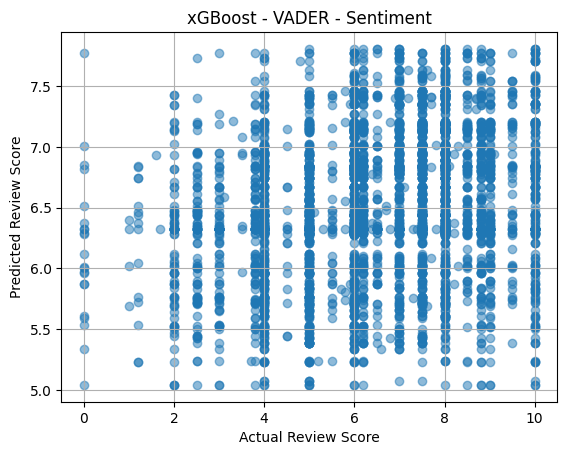

VADER with Sentiment
R²: 0.2270197545756838
Match Rate:  0.12208504801097393


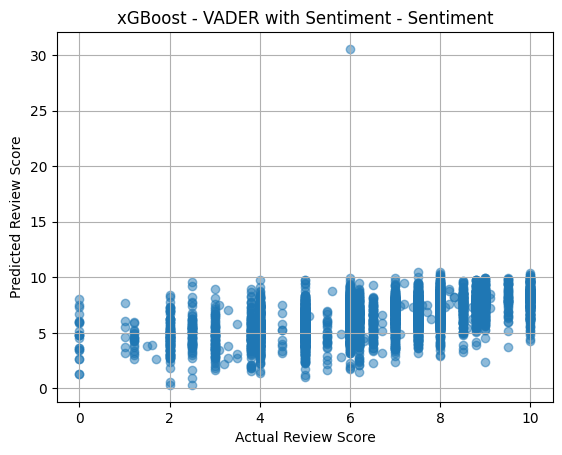

FilmBERT
R²: 0.5011502860248651
Match Rate:  0.16194609410689811


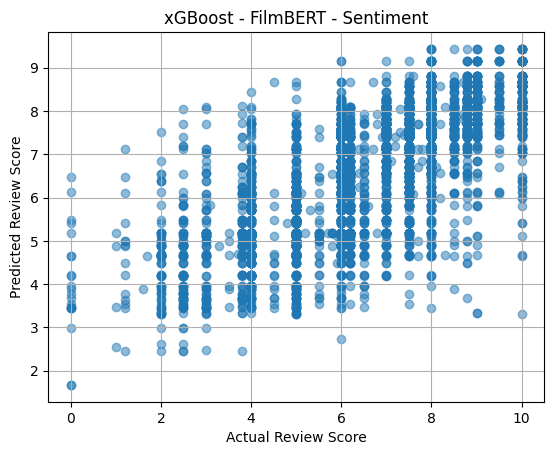

FilmBERT with Sentiment
R²: 0.28226136321746553
Match Rate:  0.16140832190214907


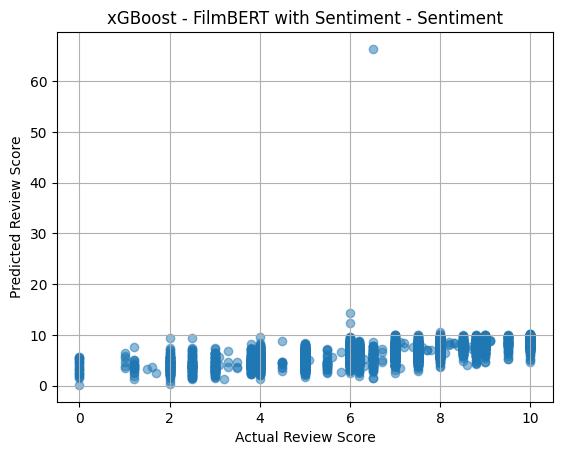

Distilled RoBERTa
R²: 0.0019198446130690439
Match Rate:  0.11512105984467794


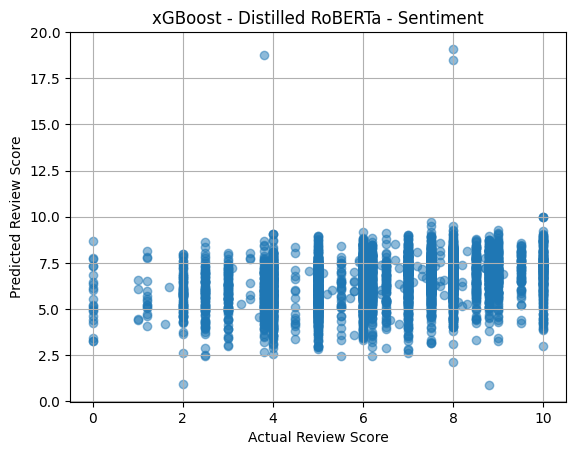

Distilled RoBERTa with Sentiment
R²: -0.6247209968095
Match Rate:  0.13008687700045724


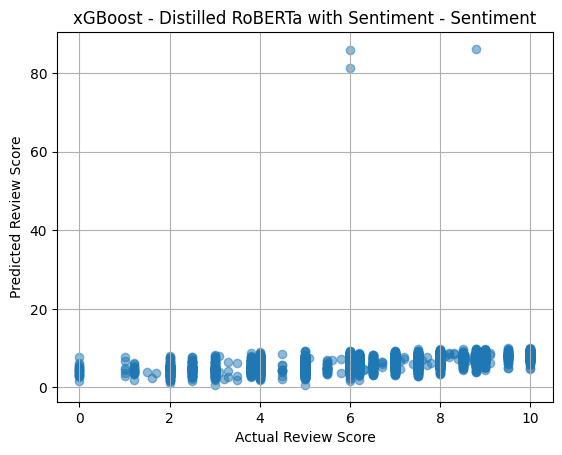

Twitter RoBERTa
R²: -0.16839952881336417
Match Rate:  0.11397898583828232


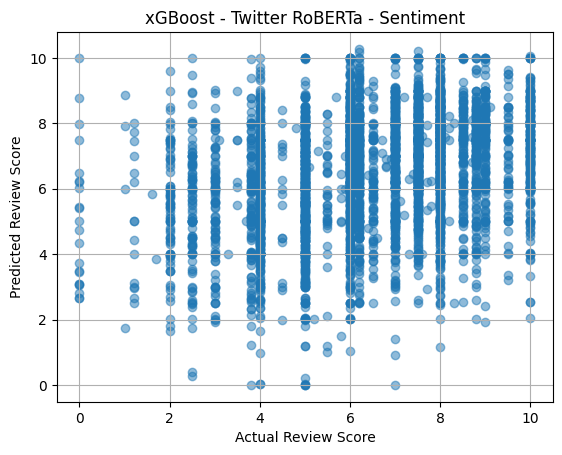

Twitter RoBERTa with Sentiment
R²: 0.38967162574693326
Match Rate:  0.14288980338363055


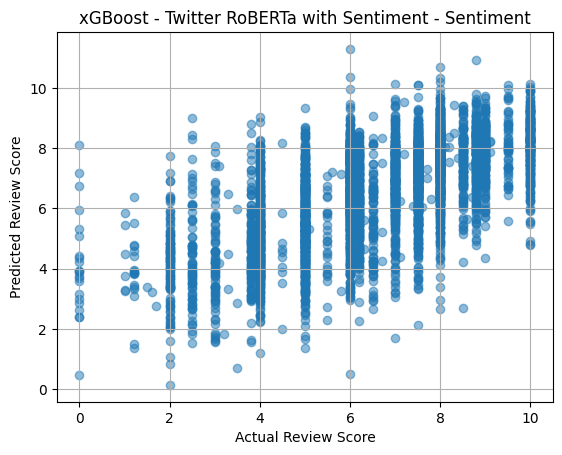

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb

def loop(model_name, score_path):
    film_df = pd.read_csv(score_path, header=0)
    film_df = film_df.dropna()
    X = film_df.drop(columns=['review_score_clean'], axis=1)
    y = film_df['review_score_clean']

    # Split into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = xgb.XGBRegressor(n_estimators=700, learning_rate=0.09, max_depth=20, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    y_true  = y_test.values if hasattr(y_test, "values") else y_test

    r2 = r2_score(y_test, y_pred)
    print("R²:", r2)

    match_rate = np.mean(np.abs(y_pred - y_test) < .25)  # .25-point margin
    print("Match Rate: ", match_rate)

    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.xlabel('Actual Review Score')
    plt.ylabel('Predicted Review Score')
    plt.title(f"xGBoost - {model_name} - Sentiment")
    plt.grid(True)
    plt.show()

sentiment_list = {
    "VADER": "/content/drive/MyDrive/AIP4/data/sentiment/vader.csv",
    "VADER with Sentiment": "/content/drive/MyDrive/AIP4/data/sentiment_meta/vader.csv",
    "FilmBERT": "/content/drive/MyDrive/AIP4/data/sentiment/film_bert.csv",
    "FilmBERT with Sentiment": "/content/drive/MyDrive/AIP4/data/sentiment_meta/film_bert.csv",
    "Distilled RoBERTa": "/content/drive/MyDrive/AIP4/data/sentiment/distilled_roberta.csv",
    "Distilled RoBERTa with Sentiment": "/content/drive/MyDrive/AIP4/data/sentiment_meta/distilled_roberta.csv",
    "Twitter RoBERTa": "/content/drive/MyDrive/AIP4/data/sentiment/twitter_roberta.csv",
    "Twitter RoBERTa with Sentiment": "/content/drive/MyDrive/AIP4/data/sentiment_meta/twitter_roberta.csv"
}

for key in sentiment_list:
    print(key)
    score_path = sentiment_list[key]
    loop(key, score_path)


This is the custom model I am training, called FilmBERT. It trains a model specificly to identify relationships between review content and review scores.

**IF YOU RUN THIS CELL, USE THE FOLLOWING KEY WHEN PROMPTED**  
wandb API: 6dfb91c3fe0d75a1556580fcdce2a3eb3aa83fad

# FilmBERT Training

In [ ]:
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split

df = pd.read_csv('/content/drive/MyDrive/AIP4/data/movie_metadata-trainer.csv')

df = df[['review_content', 'review_score_clean']].dropna()
df = df.sample(n=10000, random_state=42)  # change to 18000 if you want full run

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)
dataset = DatasetDict({'train': train_dataset, 'test': test_dataset})

model_name = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(batch):
    return tokenizer(batch['review_content'], padding="max_length", truncation=True, max_length=256)

tokenized = dataset.map(tokenize_function, batched=True)
tokenized = tokenized.rename_column("review_score_clean", "labels")
tokenized.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=1)

training_args = TrainingArguments(
    output_dir="./filmbert-regression",
    per_device_train_batch_size=8,
    num_train_epochs=4,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="loss",
    greater_is_better=False,
    learning_rate=1e-5
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["test"]
)

trainer.train()

preds = trainer.predict(tokenized["test"])
pred_scores = preds.predictions.squeeze()
true_scores = preds.label_ids

trainer.save_model("/content/drive/MyDrive/models/filmbert-regression-final")
tokenizer.save_pretrained("/content/drive/MyDrive/models/filmbert-regression-final")



Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,2.462300,2.546222
2,2.507700,2.702329
3,2.075700,2.403188
4,1.270900,2.570429


('/content/drive/MyDrive/models/filmbert-regression-final/tokenizer_config.json',
 '/content/drive/MyDrive/models/filmbert-regression-final/special_tokens_map.json',
 '/content/drive/MyDrive/models/filmbert-regression-final/vocab.json',
 '/content/drive/MyDrive/models/filmbert-regression-final/merges.txt',
 '/content/drive/MyDrive/models/filmbert-regression-final/added_tokens.json',
 '/content/drive/MyDrive/models/filmbert-regression-final/tokenizer.json')

Generate Sentiment Using the FilmBERT model

In [ ]:
import pandas as pd
from warnings import simplefilter
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax
import torch
from tqdm.notebook import tqdm

simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

movie_df = pd.read_csv(csv_path)

print("Generating sentiment scores... This will take a few minutes")
model_path = "/content/drive/MyDrive/AIP4/models/filmbert-regression-final"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

# Predict score for a new review
def predict_score(text):
  inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=256)
  inputs = {k: v.to(device) for k, v in inputs.items()}  # Move to GPU
  with torch.no_grad():
      output = model(**inputs).logits
  return output.item()

tqdm.pandas() # visualizer

movie_df['sentiment'] = movie_df['review_content'].progress_apply(lambda text: predict_score(text))
movie_df['sentiment'] = round(movie_df['sentiment'] / 10, 2)

# remove unused data
print("Dropping unused keys...")
# A lot of this data is parsed by this point or isn't relevant to the training model.
movie_df = movie_df.drop(columns=['review_content'], errors='ignore')

# isolate from meta data if desired
# movie_df = movie_df[['review_score_clean','sentiment']]

print("Writing data... This will take a few minutes")
movie_df.to_csv("/content/drive/MyDrive/AIP4/data/sentiment_meta/film_bert.csv", index=False)
print("Processing complete")


Generating sentiment scores... This will take a few minutes


  0%|          | 0/21889 [00:00<?, ?it/s]

Dropping unused keys...
Writing data... This will take a few minutes
Processing complete
